<a href="https://colab.research.google.com/github/kiryu-3/Prmn2023/blob/main/Python/Python_Machine/Machine_Learning_8_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 分類モデルの評価指標ー知識編

In [ ]:
# 最初にインポートしてください
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, log_loss
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
import statsmodels.api as sma

回帰モデルの評価指標には、以下のようなものがあります。

- MSE
- RMSE
- MAE
- $R^2$



分類モデル（分類器）の評価指標は、回帰モデルに比べてさらに多くの評価指標があります。  
しかし、それらの分類器は、したい評価によって使用するべき評価指標が変わります。

適切な評価指標を使えるようになることが目標となります。

## 混同行列

二値分類において、0を**陰性(negative)**, 1を**陽性(positive)**と呼ぶことがあります。

例えば、喫煙者かどうかを予測したい場合、  
喫煙者ではない場合を陰性、喫煙者の場合を陽性とするのが一般的です。

また、これらのpositive/negativeのデータに対して予測した結果、  
正解していることを**真(True)**，間違っていることを**偽(False)**と言います。

これらを組み合わせた、以下のような指標が存在します。  
正解ラベルに対しての正解/不正解かを表す指標です。

- <font color=red>**T**</font>rue <font color=red>**P**</font>ositive：**真陽性**（<font color=red>**TP**</font>）
- <font color=red>**T**</font>rue <font color=red>**N**</font>egative：**真陰性**（<font color=red>**TN**</font>）
- <font color=blue>**F**</font>alse <font color=blue>**P**</font>ositive：**真陽性**（<font color=blue>**FP**</font>）
- <font color=blue>**F**</font>alse <font color=blue>**N**</font>egative：**真陰性**（<font color=blue>**FN**</font>）

データセットで各クラスがいくつ正解/不正解しているかを表す行列(表)を、  
**混同行列**（Confusion Matrix）といいます。

一目でモデルの分類傾向を確認できます。

![](https://imgur.com/EkR3MHY.png)

例として、正解データと予測データが以下のようにあったとします。

![](https://imgur.com/rrcDWhX.png)

このときの混同行列は以下のようになります。

![](https://imgur.com/egnSydr.png)

###

####  使用するデータセット（二値分類）

では、実際のデータを使って、  
Pythonで混同行列を計算・表示させてみます。


今回は、seabornのサンプル用データセット"tips"を利用します。

データセットは、pandas.DataFrameオブジェクトとして取得することができます。

（参考サイト：[こちら](https://biotech-lab.org/articles/1408#i)）

In [ ]:
tips = sns.load_dataset('tips')
tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.4 KB


"tips"のデータの説明は以下の通りです。

- total_bill : 総支払額(食事代、税込み)　(USドル)
- tip : チップ(USドル)
- sex : 性別
- smoker : 喫煙者か否か
- day : 曜日(木・金・土・日のいずれか)
- time : 食事の時間(昼食か夕食か)
- size : 人数

また、今回のデータには欠損値はなさそうです。

#### Pythonで混同行列の計算・表示（二値分類）

では、実際にPythonで混同行列を表示してみましょう。

今回は使用するカラムを増やしたいので、one-hotエンコーディングを行います。

In [ ]:
# smoker カラム以外のカテゴリカル変数をダミー変数に変換
tips = pd.get_dummies(tips, columns=["sex", "day", "time"], drop_first=True)
tips.head()

,total_bill,tip,smoker,size,sex_Female,day_Fri,day_Sat,day_Sun,time_Dinner
0,16.99,1.01,No,2,1,0,0,1,1
1,10.34,1.66,No,3,0,0,0,1,1
2,21.01,3.50,No,3,0,0,0,1,1
3,23.68,3.31,No,2,0,0,0,1,1
4,24.59,3.61,No,4,1,0,0,1,1


喫煙者の割合を知りたいので出してみましょう。

In [ ]:
tips['smoker'].value_counts()

No     151
Yes     93
Name: smoker, dtype: int64

訓練データとテストデータを作ります。

今回は、"smoker"カラムの値（喫煙者かどうか）を予測するとします。

In [ ]:
# 目的変数に"smoker"、説明変数にそれ以外のカラムを指定
x = tips.drop('smoker', axis=1)
y = tips['smoker']

# データを訓練データとテストデータに分ける
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, stratify=y)

# 説明変数のデータを標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

# モデル学習
model = LogisticRegression(penalty='none')
model.fit(x_train_scaled, y_train)

# 予測
y_pred = model.predict(x_test_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


では、混同行列を表示してみましょう。

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix(y_test, y_pred, labels=['Yes', 'No'])

array([[13, 15],
       [15, 31]])

この形だとイマイチ分かりづらいので、  
混同行列を綺麗に表示してみます。

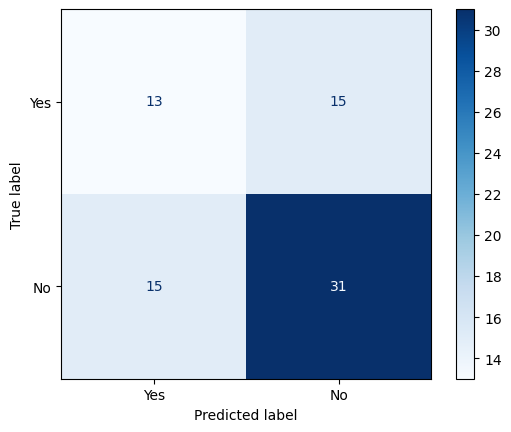

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=['Yes', 'No'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Yes', 'No'])
disp.plot(cmap=plt.cm.Blues)

heatmapで混同行列を表示することができました。

以下のような結果が得られたことが分かります。

- <font color=red>**TP**</font>：13（左上）
- <font color=red>**TN**</font>：31（右下）
- <font color=blue>**FP**</font>：15（左下）
- <font color=blue>**FN**</font>：15（右上）

####  使用するデータセット（多値分類）

次に、Scikit-learnのデータセット"iris"を利用します。


（参考サイト：[こちら](https://zenn.dev/nekoallergy/articles/scikit-learn-datasets#%E3%82%B5%E3%83%B3%E3%83%97%E3%83%AB%E3%83%87%E3%83%BC%E3%82%BF%E3%81%AE%E7%A8%AE%E9%A1%9E)）

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()

df = pd.DataFrame(iris.data, columns=iris.feature_names)
df["target"] = iris.target

df["target"][df["target"] == 0] = "setosa"
df["target"][df["target"] == 1] = "versicolor"
df["target"][df["target"] == 2] = "virginica"

# レコード件数、カラム数、欠損値の存在、データ型の確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


<ipython-input-9-acfe246a3896>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"][df["target"] == 0] = "setosa"


"iris"のデータの説明は以下の通りです。

- 4つのデータがある
  - sepal length（がく片の長さ）
  - sepal width（がく片の幅）
  - petal length（花びらの長さ）
  - petal width（花びらの幅）
- 3種類の分類がある（それぞれ50個）
  - setosa（セトーサ、ヒオウギアヤメ）
  - versicolour（ヴァーシカラー、ブルーフラッグ）
  - virginica（ヴァージニカ、ヴァージニカ）

また、今回のデータには欠損値はなさそうです。

#### Pythonで混同行列の計算・表示（多値分類）

では、実際にPythonで混同行列を表示してみましょう。

アヤメの品種の割合を知りたいので出してみましょう。

In [ ]:
df['target'].value_counts()

setosa        50
versicolor    50
virginica     50
Name: target, dtype: int64

訓練データとテストデータを作ります。

今回は、"target"カラムの値（アヤメの品種）を予測するとします。

In [ ]:
# 目的変数に"target"、説明変数にそれ以外のカラムを指定
x = df.drop('target', axis=1)
y = df['target']

# データを訓練データとテストデータに分ける
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0, stratify=y)

# 説明変数のデータを標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

# モデル学習
model = LogisticRegression(penalty='none')
model.fit(x_train_scaled, y_train)

# 予測
y_pred = model.predict(x_test_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


では、混同行列を表示してみましょう。

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix(y_test, y_pred, labels=['setosa', 'versicolor', 'virginica'])

array([[25,  0,  0],
       [ 0, 24,  1],
       [ 0,  3, 22]])

この形だとイマイチ分かりづらいので、  
混同行列を綺麗に表示してみます。

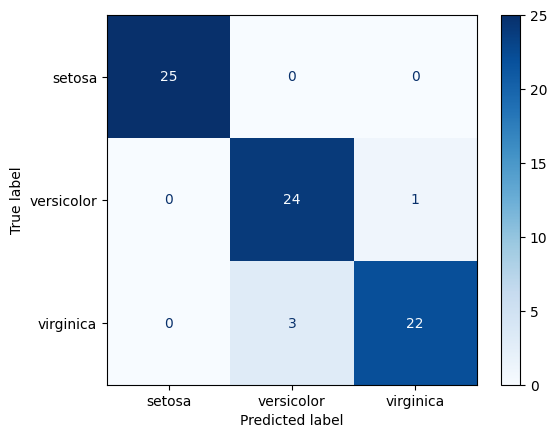

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=['setosa', 'versicolor', 'virginica'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['setosa', 'versicolor', 'virginica'])
disp.plot(cmap=plt.cm.Blues)

heatmapで混同行列を表示することができました。

virginicaのデータをsersicolorと予測しているのが3件あるようです。

## Accuracy

**Accuracy(正解率)は**，全てのデータの中で  
どれくらい正解しているかを表す指標です。

数式で表すと以下のようになります。  
簡単に言うと、**正解の数/全データ**　ですね。

$$
Accuracy=\frac{TP+TN}{TP+TN+FP+FN}
$$

先ほど例で登場したデータです。

![](https://imgur.com/rrcDWhX.png)

![](https://imgur.com/egnSydr.png)

この場合、Accuracyは$\frac{4}{8}=0.5$となります。

### Accuracyの問題点

Accuracyですが、以下のように、  
評価するデータセットが**PositiveとNegativeの割合に偏りがある**場合は注意が必要です。

![](https://imgur.com/uSHAjee.png)

上のモデルは、正解がどんなものでも予測値を0としてしまうものとなっています。  
このような場合でも、Accuracyは$\frac{7}{8}=0.875$とかなり高い値が出てしまいます。

このようなモデルができてしまう原因となるのが、  
クラスのデータ数に偏りがあることです。

その場合は、この後紹介する他の指標を用いる必要があります。

### PythonでAccuracyの導出

In [ ]:
# サンプルデータ
y_true = [1, 1, 0, 0, 1, 0, 1, 1]
y_pred = [1, 0, 1, 0, 0, 1, 1, 1]

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.5

In [ ]:
# サンプルデータ
y_true = [0, 0, 0, 0, 1, 0, 0, 0]
y_pred = [0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.875

## Precision

**Precision(適合率)は**，"陽性"と分類した中で  
実際に"陽性"である割合を表す指標です。

PPV(Positive Predictive Value)ということもあるようです。

数式で表すと以下のようになります。  
簡単に言うと、陽性と予測されたデータが、実際どれだけ陽性だったかということですね。

$$
Precision=\frac{TP}{TP+FP}
$$

先ほど例で登場したデータです。

![](https://imgur.com/rrcDWhX.png)

![](https://imgur.com/egnSydr.png)

この場合、Precisionは$\frac{3}{5}=0.6$となります。

### Precisionの特徴

Precisionですが、以下のように、  
評価するデータセットがPositiveとNegativeの割合に偏りがある場合でも、  
それが**陽性が極端に少ない場合であれば**偏ったケースも適切に評価できることがあります。

![](https://imgur.com/uSHAjee.png)

しかし、**陰性が極端に少ない場合**では、適切に評価できないことがあります。  
（100%に近い精度が出てしまう）

### PythonでPrecisionの導出

In [ ]:
# サンプルデータ
y_true = [1, 1, 0, 0, 1, 0, 1, 1]
y_pred = [1, 0, 1, 0, 0, 1, 1, 1]

In [ ]:
from sklearn.metrics import precision_score
precision_score(y_true, y_pred)

0.6

In [ ]:
# サンプルデータ
y_true = [0, 0, 0, 0, 1, 0, 0, 0]
y_pred = [0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
from sklearn.metrics import precision_score
precision_score(y_true, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

## Recall

**Recall(再現率)は**，"陽性"と分類した中で  
どれだけ正しく"陽性"と予測できていたかを表す指標です。


数式で表すと以下のようになります。  
簡単に言うと、実際陽性のデータの内、どれだけ陽性であろうと予測したかということですね。

$$
Recall=\frac{TP}{TP+FN}
$$

先ほど例で登場したデータです。

![](https://imgur.com/rrcDWhX.png)

![](https://imgur.com/egnSydr.png)

この場合、Recallは$\frac{3}{5}=0.6$となります。

### Recallの特徴

Recallですが、以下のように、  
評価するデータセットがPositiveとNegativeの割合に偏りがある場合でも、  
それが**陽性が極端に少ない場合であれば**偏ったケースも適切に評価できることがあります。

![](https://imgur.com/uSHAjee.png)

しかし、**陰性が極端に少ない場合**では、適切に評価できないことがあります。  
（100%に近い精度が出てしまう）

### PythonでRecallの導出

In [ ]:
# サンプルデータ
y_true = [1, 1, 0, 0, 1, 0, 1, 1]
y_pred = [1, 0, 1, 0, 0, 1, 1, 1]

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_true, y_pred)

0.6

In [ ]:
# サンプルデータ
y_true = [0, 0, 0, 0, 1, 0, 0, 0]
y_pred = [0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_true, y_pred)

0.0

In [ ]:
# サンプルデータ
y_true = [1, 1, 1, 1, 0, 1, 1, 1]
y_pred = [1, 1, 1, 1, 1, 1, 1, 1]
np.array(y_true)!=1

array([False, False, False, False,  True, False, False, False])

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_true, y_pred)

1.0

## Specificity

**Specificity(特異度)は**，"陰性"と分類した中で  
どれだけ正しく"陰性"と予測できていたかを表す指標です。

Recallの陰性バージョンですね。


数式で表すと以下のようになります。  
簡単に言うと、実際陰性のデータの内、どれだけ陰性であろうと予測したかということですね。

$$
Specificity=\frac{TN}{TN+FP}
$$

先ほど例で登場したデータです。

![](https://imgur.com/rrcDWhX.png)

![](https://imgur.com/egnSydr.png)

この場合、Specificityは$\frac{1}{3}=0.33$となります。

### Specificityの特徴

Specificityですが、以下のように、  
評価するデータセットがPositiveとNegativeの割合に偏りがある場合でも、  
それが**陰性が極端に少ない場合であれば**偏ったケースも適切に評価できることがあります。

![](https://imgur.com/uSHAjee.png)

しかし、**陽性が極端に少ない場合**では、適切に評価できないことがあります。  
（100%に近い精度が出てしまう）

### PythonでSpecificityの導出

Specificityの計算はsklearnには実装されていません。

データの陽性と陰性を逆にして、Recallを求めれば計算となります。

In [ ]:
# サンプルデータ
y_true = [1, 1, 0, 0, 1, 0, 1, 1]
y_pred = [1, 0, 1, 0, 0, 1, 1, 1]
np.array(y_true)!=1

array([False, False,  True,  True, False,  True, False, False])

In [ ]:
from sklearn.metrics import recall_score

res = []
for c in [0, 1]:
    res.append(recall_score(np.array(y_true)!=c, np.array(y_pred)!=c))
res

[0.6, 0.3333333333333333]

In [ ]:
# サンプルデータ
y_true = [0, 0, 0, 0, 1, 0, 0, 0]
y_pred = [0, 0, 0, 0, 0, 0, 0, 0]
np.array(y_true)!=1

array([ True,  True,  True,  True, False,  True,  True,  True])

In [ ]:
from sklearn.metrics import recall_score

res = []
for c in [0, 1]:
    res.append(recall_score(np.array(y_true)!=c, np.array(y_pred)!=c))
res

[0.0, 1.0]

In [ ]:
# サンプルデータ
y_true = [1, 1, 1, 1, 0, 1, 1, 1]
y_pred = [1, 1, 1, 1, 1, 1, 1, 1]
np.array(y_true)!=1

array([False, False, False, False,  True, False, False, False])

In [ ]:
from sklearn.metrics import recall_score

res = []
for c in [0, 1]:
    res.append(recall_score(np.array(y_true)!=c, np.array(y_pred)!=c))
res

[1.0, 0.0]

## 多クラスでの評価指標の計算の仕方

Precision,Recall,Specificityを計算する際、  
多クラスの場合は工夫が必要です。

あるクラスをPositiveとしてその他のクラスをNegativeとすると、  
クラスの数だけパターンができてしまうからです。

そのため、計算する際はクラスレベルで平均を取り、   
それを単純に算術平均します。

これを**macro平均**と言います。

一方、データレベルで平均を取るやり方を  
**micro平均**と言います。

以下のような場合を例として取り上げます。  
今回使う評価指標は**Accuracy**です。

- クラスA：データ数100、Accuracyが0.1
- クラスB：データ数50、Accuracyが0.5
- クラスC：データ数10、Accuracyが0.3

この場合、macro平均とmicro平均は以下のようになります。  
（10, 25, 3 はそれぞれの正解数）


$$
macro = \frac{0.1+0.5+0.3}{3}=0.3
$$

$$
micro = \frac{10+25+3}{160}=約0.24
$$



これを他の評価指標に適用するとどうなるでしょう。  
ここでは、**Precision**を例とします。

Precisionの式は$\frac{TP}{TP+FP}$でした。

あるクラスのTNは他のクラスのTPになるので、  
TPはTP+TNとなります。

また、同様にあるクラスのFPは他のクラスのFNもしくはTNになるので、  
FPはFP+FN+TNになります。

このことから、データ全体でTP，FPを数えると、  
結局他のクラスのTN, FNもカウントされてしまうことが分かります。

つまり、**Precisionのmicro平均はAccuracyと同じになる**ということです。



これはrecall, specificityについても同じです。

そのため、**Accuracyは通常micro平均**を、  
**Precision, recall, specificityは通常macro平均**を取ることになります。

###  使用するデータセット（評価指標計算）

では、実際のデータを使って、  
Pythonで指標を計算させてみます。

ここでもまた、Scikit-learnのデータセット"iris"を利用します。


（参考サイト：[こちら](https://zenn.dev/nekoallergy/articles/scikit-learn-datasets#%E3%82%B5%E3%83%B3%E3%83%97%E3%83%AB%E3%83%87%E3%83%BC%E3%82%BF%E3%81%AE%E7%A8%AE%E9%A1%9E)）

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()

df = pd.DataFrame(iris.data, columns=iris.feature_names)
df["target"] = iris.target

df["target"][df["target"] == 0] = "setosa"
df["target"][df["target"] == 1] = "sersicolor"
df["target"][df["target"] == 2] = "virginica"

# レコード件数、カラム数、欠損値の存在、データ型の確認
df.info()

<ipython-input-35-15050d26f2b8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"][df["target"] == 0] = "setosa"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


"iris"のデータの説明は以下の通りです。

- 4つのデータがある
  - sepal length（がく片の長さ）
  - sepal width（がく片の幅）
  - petal length（花びらの長さ）
  - petal width（花びらの幅）
- 3種類の分類がある（それぞれ50個）
  - setosa（セトーサ、ヒオウギアヤメ）
  - versicolour（ヴァーシカラー、ブルーフラッグ）
  - virginica（ヴァージニカ、ヴァージニカ）

また、今回のデータには欠損値はなさそうです。

訓練データとテストデータを作ります。

今回は、"target"カラムの値（アヤメの品種）を予測するとします。

In [ ]:
# 目的変数に"target"、説明変数にそれ以外のカラムを指定
x = df.drop('target', axis=1)
y = df['target']

# データを訓練データとテストデータに分ける
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0, stratify=y)

# 説明変数のデータを標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

# モデル学習
model = LogisticRegression(penalty='none')
model.fit(x_train_scaled, y_train)

# # 現在の classes_ 属性の値を取得
# current_classes = model.classes_
# # 新しいクラスの順序に入れ替える（ここでは逆順に）
# model.classes_ = current_classes[::-1]

# 予測
y_pred = model.predict(x_test_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


### Accuracyの導出（多クラス）

まずはAccuracyです。  
micro平均しかそもそも求められないようです。

In [ ]:
from sklearn.metrics import accuracy_score

# Accuracy
print(accuracy_score(y_test, y_pred))

0.96


### Precisionの導出（多クラス）

次はPrecisionです。  
各クラスの評価・macro平均・micro平均を求めます。

In [ ]:
from sklearn.metrics import precision_score

# classes
print(model.classes_)
# None
print(precision_score(y_test, y_pred, average=None))
# macro
print(precision_score(y_test, y_pred, average='macro'))
# micro
print(precision_score(y_test, y_pred, average='micro'))

['sersicolor' 'setosa' 'virginica']
[0.89285714 1.         1.        ]
0.9642857142857143
0.96


### Recallの導出（多クラス）

次はRecallです。  
各クラスの評価・macro平均・micro平均を求めます。

In [ ]:
from sklearn.metrics import recall_score

# classes
print(model.classes_)
# None
print(recall_score(y_test, y_pred, average=None))
# macro
print(recall_score(y_test, y_pred, average='macro'))
# micro
print(recall_score(y_test, y_pred, average='micro'))

['sersicolor' 'setosa' 'virginica']
[1.   1.   0.88]
0.96
0.96


### Specificityの導出（多クラス）

最後はSpecificityです。  
各クラスの評価・macro平均を求めます。

In [ ]:
from sklearn.metrics import recall_score

res = []

for c in model.classes_:
    res.append(recall_score(np.array(y_test)!=c, np.array(y_pred)!=c))

print(f"Model：{model.classes_}")
print(f"None：{res}")
print(f"Macro：{np.mean(res)}")

Model：['sersicolor' 'setosa' 'virginica']
None：[0.94, 1.0, 1.0]
Macro：0.98


## F値

実は、Recall($\frac{TP}{TP+FN}$)とPrecision($\frac{TP}{TP+FP}$)はトレードオフの関係にあって、  
片方を高くしようとすると、もう片方が低くなる関係にあります。

例えば、**Recallを高くしよう**として積極的に"Positive"と予測する場合、  
本当はPositiveだけどNegativeと誤ってしまう(FN)数は下がりRecallは高くなりますが、  
本当はNegativeなのにPositiveと誤ってしまう(FP)数が増えてしまうので、  
**Precisionは下がってしまいます**。

![](https://imgur.com/JsYhMuS.png)

そのため、RecallやPrecision単体でみても、  
一概に精度の良し悪しは言えません。

そこで用いるのが**F値(F-score)**になります。  
RecallとPrecisionの調和平均（参考：[こちら](https://datawokagaku.com/rep_val/#i-4)の記事）を取ります。

F値はこのトレードオフを考慮して調和平均を取った値になっています。

数式は以下の通りです。

$$
\text{F-score}=\frac{2}{\frac{1}{\text{Recall}}+\frac{1}{\text{Precision}}}=\frac{2\times \text{Recall}\times \text{Precision}}{\text{Recall} + \text{Precision}}
$$

特にこだわりがなければ、評価指標にF値を使うことが多いようです。

### PythonでF値の導出

PrecisionとRecallの調和平均を取った値、  
F値をPythonで求めてみましょう。


In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score

# サンプルデータ
y_true = [1, 1, 0, 0, 1, 0, 1, 1]
y_pred = [1, 0, 1, 0, 0, 1, 1, 1]

# F1
print(f"F値：{f1_score(y_true, y_pred)}")
# recall
print(f"recall：{recall_score(y_true, y_pred)}")
# precision
print(f"precision：{precision_score(y_true, y_pred)}")

# 調和平均ver
from scipy.stats import hmean
print(f"F値：{hmean([recall_score(y_true, y_pred), precision_score(y_true, y_pred)])}")

F値：0.6
recall：0.6
precision：0.6
F値：0.6


In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score

# サンプルデータ
y_true = [0, 0, 0, 0, 1, 0, 0, 0]
y_pred = [0, 0, 0, 0, 0, 0, 0, 0]

# F1
print(f"F値：{f1_score(y_true, y_pred)}")
# recall
print(f"recall：{recall_score(y_true, y_pred)}")
# precision
print(f"precision：{precision_score(y_true, y_pred)}")

# 調和平均ver
from scipy.stats import hmean
print(f"F値：{hmean([recall_score(y_true, y_pred), precision_score(y_true, y_pred)])}")

F値：0.0
recall：0.0
precision：0.0
F値：0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score

# サンプルデータ
y_true = [1, 1, 1, 1, 0, 1, 1, 1]
y_pred = [1, 1, 1, 1, 1, 1, 1, 1]

# F1
print(f"F値：{f1_score(y_true, y_pred)}")
# recall
print(f"recall：{recall_score(y_true, y_pred)}")
# precision
print(f"precision：{precision_score(y_true, y_pred)}")

# 調和平均ver
from scipy.stats import hmean
print(f"F値：{hmean([recall_score(y_true, y_pred), precision_score(y_true, y_pred)])}")

F値：0.9333333333333333
recall：1.0
precision：0.875
F値：0.9333333333333333


### Precision-Recall Curve

閾値に対するPrecisionとRecallの推移を表した図が  
**Precision-Recall Curve**です。

では、実際のデータを使って、  
PythonでPrecision-Recall Curveを描画してみます。


今回は、seabornのサンプル用データセット"tips"を利用します。


In [ ]:
tips = sns.load_dataset('tips')

# smoker カラム以外のカテゴリカル変数をダミー変数に変換
tips = pd.get_dummies(tips, columns=["sex", "day", "time"], drop_first=True)

# "smoker"カラムを数値型に変換
mapping = {"No" : 0, "Yes" : 1}
tips['smoker'] = tips['smoker'].map(mapping)
tips['smoker'].value_counts()

# 目的変数に"smoker"、説明変数にそれ以外のカラムを指定
x = tips.drop('smoker', axis=1)
y = tips['smoker']

# データを訓練データとテストデータに分ける
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0, stratify=y)

# 説明変数のデータを標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

from sklearn.linear_model import LogisticRegression
# モデル学習
model = LogisticRegression(penalty='none')
model.fit(x_train_scaled, y_train)

# 予測
y_pred = model.predict(x_test_scaled)
y_pred_proba = model.predict_proba(x_test_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


では実際に描画してみましょう。

In [ ]:
from sklearn.metrics import precision_recall_curve

# 陽性の確率だけが必要なので[:, 1]をして陰性の確率を落とす
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba[:, 1])

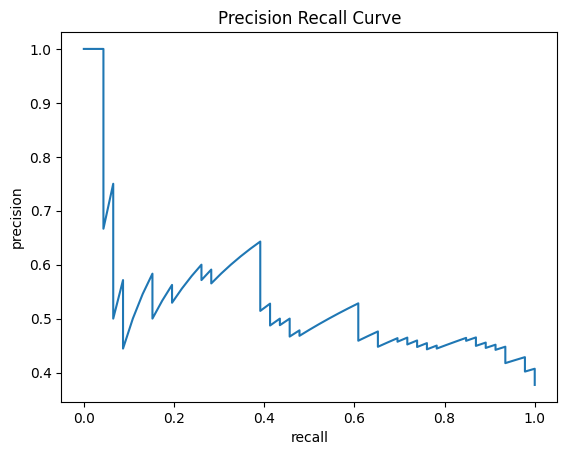

In [ ]:
import matplotlib.pyplot as plt
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision Recall Curve')
plt.show()

### Precision,Recall,F値の推移

PrecisionとRecallをどちらも平均的に高くなるような閾値を選択したい時は、  
F値が最も高くなる閾値を選ぶのが一般的です。

それぞれのPrecisionとRecallに対して、  
F値がどのように変化するかどうか描画してみましょう。

In [ ]:
# それぞれのprecisionとrecallにおけるF値(調和平均)を計算
f1_scores = [hmean([p, r]) for p, r in zip(precision, recall)]

36th threshold(=0.26) is the highest f1 score = 0.61


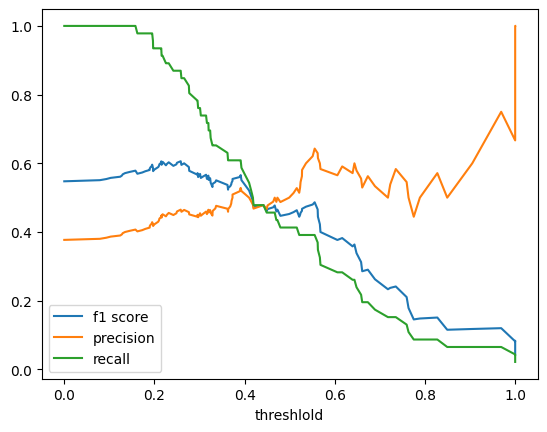

In [ ]:
plt.plot(thresholds, f1_scores[:-1], label='f1 score')
plt.plot(thresholds, precision[:-1], label='precision')
plt.plot(thresholds, recall[:-1], label='recall')
plt.xlabel('threshlold')
plt.legend()
print(f'{np.argmax(f1_scores)}th threshold(={thresholds[np.argmax(f1_scores)]:.2f}) is the highest f1 score = {np.max(f1_scores):.2f}')

F値が最も高いのは閾値が0.26のときです。

図を見てもわかるように、  
RecallもPrecisionもどちらもある程度高くなっています。

普通にロジスティック回帰を構築して `model.predict()` をすると、  
閾値が0.5の場合での予測になってしまいます。

このようにF値がもっとも高くなるような閾値を探すことで、  
より精度の高いモデルを作ることができます。

## ROC

**ROC**は，Receiver Operating Characteristicの略です。

分類器の評価で最も使われる指標の一つです。

トレードオフの関係は、RecallとPrecisionの間に存在しましたが、  
**RecallとSpecificityの間**にも存在します。

Recallですが、Specificityの対比でよく使われるのは**"Sensitivity"**という呼ばれ方です。

ROCの説明の中では、**"Recall"を"Sensitivity"と呼ぶ**こととします。


Precision-Recall Curveと同様に、  
横軸**"1-Specificity"**, 縦軸**"SensiAvity"**とした時に閾値の変化が描くカーブが**ROC**です。

ROCの文脈では、Sensitivityは**True Positive Rate(TPR)**,   
1-Specificityは**False Positive Rate(FPR)**ともよく呼ばれます。

$$
Sensitivity=\frac{TP}{TP+FN}
$$

$$
Specificity=\frac{TN}{TN+FP}
$$

Sensitivityは、陽性のデータに対してどれだけ正しく陽性と分類できたかの指標です。
Specificityは、陰性のデータに対してどれだけ正しく陰性と分類できたかの指標です。

"1-Specificity"は、以下の式からわかるように、  
陰性のデータに対してどれだけ陽性と"間違えたか"を意味しています。

$$
1-Specificity=1-\frac{TN}{TN+FP}=\frac{TN+FP}{TN+FP}-\frac{TN}{TN+FP}=\frac{FP}{TN+FP}
$$

Sensitivityを上げるために"陽性"と分類する頻度を上げると、  
"陰性"データを間違えて"陽性"と分類する頻度も上がり、1-Specificityも上がってしまいます。

### PythonでROCの描画

では、実際のデータを使って、PythonでROCを描画してみます。


今回は、seabornのサンプル用データセット"tips"を利用します。


In [ ]:
tips = sns.load_dataset('tips')

# smoker カラム以外のカテゴリカル変数をダミー変数に変換
tips = pd.get_dummies(tips, columns=["sex", "day", "time"], drop_first=True)

# "smoker"カラムを数値型に変換
mapping = {"No" : 0, "Yes" : 1}
tips['smoker'] = tips['smoker'].map(mapping)
tips['smoker'].value_counts()

# 目的変数に"smoker"、説明変数にそれ以外のカラムを指定
x = tips.drop('smoker', axis=1)
y = tips['smoker']

# データを訓練データとテストデータに分ける
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0, stratify=y)

# 説明変数のデータを標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

from sklearn.linear_model import LogisticRegression
# モデル学習
model = LogisticRegression(penalty='none')
model.fit(x_train_scaled, y_train)

# 予測
y_pred = model.predict(x_test_scaled)
y_pred_proba = model.predict_proba(x_test_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


では実際に描画してみましょう。

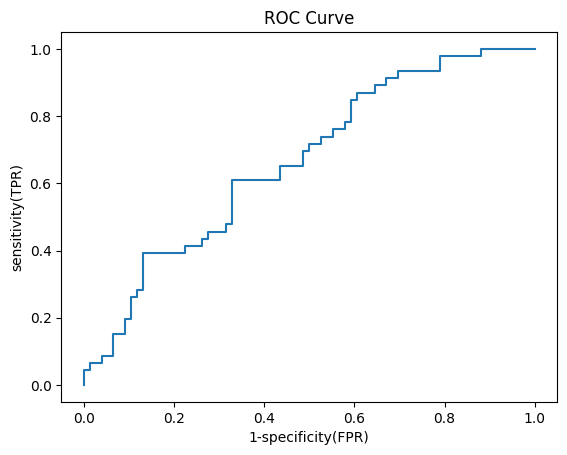

In [ ]:
from sklearn.metrics import roc_curve

# 陽性の確率だけが必要なので[:, 1]をして陰性の確率を落とす
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
# 描画
plt.plot(fpr, tpr)
plt.xlabel('1-specificity(FPR)')
plt.ylabel('sensitivity(TPR)')
plt.title('ROC Curve')
plt.show()

**Sensitivity**と**Specificity**の間に存在する、トレードオフの関係が確認できました。

## AUC

ROCカーブが作る面積が大きいと精度が高いモデルとなります。  
この面積を**AUC(Area Under the Curve)**といいます。

ROCには、以下の特徴があります。

- 当てずっぽうに予測する完全ランダムなモデルのROCは対角線になる
- 全てのデータに正しく予測できる完璧なモデルのROCは正方形の形になる

つまり以下の図のように、**ROCが描く線の下の面積**が小さくなれば精度は低く、  
大きければ精度が高いモデルになります。  


（参考：https://shorturl.at/imBG3 ）

![](https://imgur.com/ReiYqg0.png)

AUCがとりうる値は0～1ですが、ランダムなモデルのAUCが0.5であることを考えると、  
普通は0.5～1に収まると考えてよさそうです。

AUCが0.8以上あると精度が高いといえるようです。  
（データやタスクの種類によるので一概には言えない）

### PythonでAUCの計算

では、実際のデータを使って、PythonでROCを描画してみます。


今回は、seabornのサンプル用データセット"tips"を利用します。


In [ ]:
tips = sns.load_dataset('tips')

# smoker カラム以外のカテゴリカル変数をダミー変数に変換
tips = pd.get_dummies(tips, columns=["sex", "day", "time"], drop_first=True)

# "smoker"カラムを数値型に変換
mapping = {"No" : 0, "Yes" : 1}
tips['smoker'] = tips['smoker'].map(mapping)
tips['smoker'].value_counts()

# 目的変数に"smoker"、説明変数にそれ以外のカラムを指定
x = tips.drop('smoker', axis=1)
y = tips['smoker']

# データを訓練データとテストデータに分ける
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0, stratify=y)

# 説明変数のデータを標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

from sklearn.linear_model import LogisticRegression
# モデル学習
model = LogisticRegression(penalty='none')
model.fit(x_train_scaled, y_train)

# 予測
y_pred = model.predict(x_test_scaled)
y_pred_proba = model.predict_proba(x_test_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


ではROCを描画していきます。

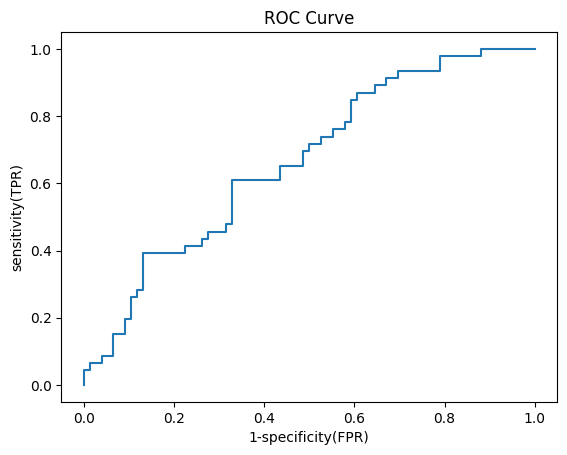

In [ ]:
from sklearn.metrics import roc_curve

# 陽性の確率だけが必要なので[:, 1]をして陰性の確率を落とす
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
# 描画
plt.plot(fpr, tpr)
plt.xlabel('1-specificity(FPR)')
plt.ylabel('sensitivity(TPR)')
plt.title('ROC Curve')
plt.show()

AUCの計算は簡単に行うことができます。

In [ ]:
from sklearn.metrics import auc
auc(fpr, tpr)

0.6644736842105263

あまり精度がいいモデルであるとはいえなさそうです。

## 多値分類におけるROCとAUC

多クラス分類の精度を考える際は、**One vs Rest**（参考サイト：[こちら](https://datawokagaku.com/multinomial/#One_vs_Rest_OvR)）が基本になります。

多クラス分類のROCでは、クラスの数分ROCを描くことができます。

#### PythonでOvRのROCの描画

ロジスティック回帰モデルで分類器を作って，ROCを描いてみます。

今回は、Scikit-learnのデータセット"iris"を利用します。

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()

df = pd.DataFrame(iris.data, columns=iris.feature_names)
df["target"] = iris.target

df["target"][df["target"] == 0] = "setosa"
df["target"][df["target"] == 1] = "sersicolor"
df["target"][df["target"] == 2] = "virginica"

# 目的変数に"target"、説明変数にそれ以外のカラムを指定
x = df.drop('target', axis=1)
y = df['target']

# データを訓練データとテストデータに分ける
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0, stratify=y)

# 説明変数のデータを標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

from sklearn.linear_model import LogisticRegression

# モデル学習
model = LogisticRegression(penalty='none')
model.fit(x_train_scaled, y_train)

# 予測
y_pred = model.predict(x_test_scaled)
# 予測(確率)
y_pred_proba = model.predict_proba(x_test_scaled)

<ipython-input-35-4f1abe6e885a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"][df["target"] == 0] = "setosa"
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


それぞれのクラス毎のROCを描いてみます。

OvRにするため、それぞれの `roc_curve()` の引数に渡す `y_true` と `y_score` は、  
それぞれのクラスに対してのラベルとスコアを渡すことになります。

今回目的変数をone-hot エンコーディングすることになりますが、  
ダミー変数にしたいわけではありません。

こういう場合は、 `sklearn.preprocessing.label_binarize` を使います。

In [ ]:
print(y_test[:5])
print(model.classes_)
print(label_binarize(y_test, classes=model.classes_)[:5])

139     virginica
15         setosa
145     virginica
56     sersicolor
129     virginica
Name: target, dtype: object
['sersicolor' 'setosa' 'virginica']
[[0 0 1]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]]


では、クラスの数だけROCを描いていきましょう。

In [ ]:
from sklearn.preprocessing import label_binarize

# one-hot エンコーディング
y_test_one_hot = label_binarize(y_test, classes=model.classes_)
# クラスの数
n_classes = len(model.classes_)
fpr = {}
tpr = {}
roc_auc = {}

# クラスの数だけROCを描く
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

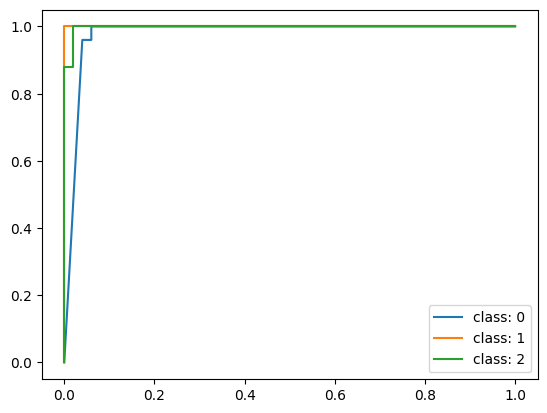

In [ ]:
# それぞれのクラスのROC
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'class: {i}')
    plt.legend()

今回、クラス1(setosa)に対しては、  
AUCが1の完璧なROCを描いていることが確認できます。

### 多クラスROCのmacro平均

多クラス分類の場合、**最終的な評価指標**を求めるために、  
macro平均もしくはmicro平均を算出します。

クラス数分のROCを描画し、その平均を取る方法がmacro平均です。  

**データ数が少ないクラスの値も重視されます**。


例えば以下のように4クラスのROCがある場合、  
その平均をとった真ん中のROCカーブになります。

（参考：https://shorturl.at/nsLU0 ）

![](https://imgur.com/pqlk63I.png)

#### PythonでROCのmacro平均の描画

In [ ]:
# 必要な（値に変化がある）xの値のリスト
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# 線形補完（単純に直線で補完する）
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr = mean_tpr / n_classes

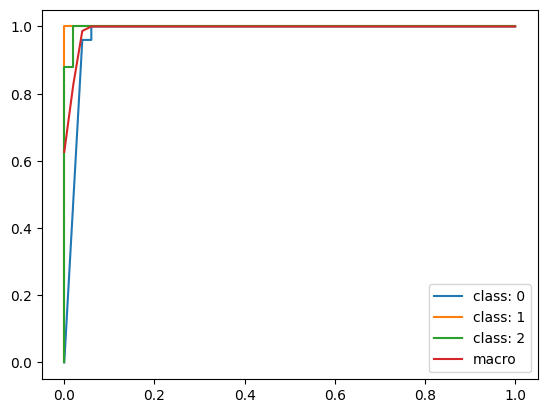

In [ ]:
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

# それぞれのクラスとmacro平均のROC
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'class: {i}')
plt.plot(fpr['macro'], tpr['macro'], label='macro')
plt.legend()

In [ ]:
from sklearn.metrics import auc
auc(fpr['macro'], tpr['macro'])

0.9925333333333333

### 多クラスROCのmicro平均

多クラス分類の場合、**最終的な評価指標**を求めるために、  
macro平均もしくはmicro平均を算出します。

クラス関係なく、各データの値を足してデータ数で割ってその平均を取る方法がmicro平均です。  

**クラス毎にデータ数に偏りがある場合、データ数が多いクラスの結果が大きく反映されてしまいます**。


#### PythonでROCのmicro平均の描画

In [ ]:
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_one_hot.ravel(), y_pred_proba.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

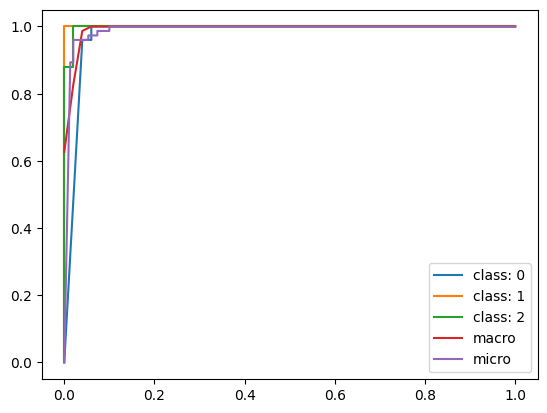

In [ ]:
# それぞれのクラスとmacro平均とmicro平均のROC
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'class: {i}')
plt.plot(fpr['macro'], tpr['macro'], label='macro')
plt.plot(fpr['micro'], tpr['micro'], label='micro')
plt.legend()

In [ ]:
from sklearn.metrics import auc
auc(fpr['micro'], tpr['micro'])

0.989688888888889

### macro平均かmicro平均か

データ数に偏りがある場合は

- データ数が小さいクラスも他のクラスと同じくらい結果に反映させたい  
→ macro平均
- データ数が多ければ多いだけ結果に反映させたい  
→ micro平均

を選択することが多いようです。